In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import re
import dlib
import random
from sklearn.metrics import accuracy_score  #混淆矩阵准确度

### 说明：
此程序用于读取原始图片数据并构建数据集，得到数据集相对应的npy文件：<br\>
1. trainDistance.npy与testDistance.npy：使用dlib库得到的128维特征距离数据集<br\>
2. trainPCA.npy与testPCA.npy：使用PCA特征降维得到的PCA数据集<br\>
3. trainLBP.npy与testLBP.npy：使用LBP图像处理后得到的直方图特征数据集<br\>
4. trainLBP_PCA.npy与testLBP_PCA.npy：使用LBP图像处理后再经过PCA特征降维得到的LBP_PCA数据集

# 一.读取有效人脸数据的标号

#### 1. 直接读取已有性别标签，均为二值化后的标签（male = 1, female = 0），DR为训练集，DS为测试集

In [28]:
DS_sex_map = np.load("data/DS_sex_map.npy")
DR_sex_map = np.load("data/DR_sex_map.npy")
print("DR: ", DR_sex_map)
print("DS: ", DS_sex_map)

DR:  [1 1 1 ... 0 0 0]
DS:  [0 0 1 ... 0 0 0]


#### 2. 得到有效训练集标签的序号集合face_DR_num

In [29]:
#face_DR: 训练集标签
with open("data/faceDR", 'r') as f:
    face_DR = f.read()

In [30]:
face_DR_num = re.findall("\d+(?=\s\(_sex)", face_DR)    #可用图片标号
face_DR_wrong = re.findall("\d+(?=\s\(_miss)", face_DR)    #缺失标签值的图片标号


for index, num in enumerate(face_DR_num):
    face_DR_num[index]=int(face_DR_num[index])

for index, wrong in enumerate(face_DR_wrong):
    face_DR_wrong[index]=int(wrong)


face_DR_sex = re.findall("(?<=sex\s\s)\w+", face_DR)    #有效性别标签
face_DR_age = re.findall("(?<=age\s\s)\w+", face_DR)    #有效年龄标签
face_DR_race = re.findall("(?<=race\s)\w+", face_DR)    #有效种族标签
face_DR_face = re.findall("(?<=face\s)\w+", face_DR)    #有效情感标签
    
print("原始数据标签个数 =", len(face_DR_num))

#将face_DR_num中含有的噪声标签去除（放入face_DR_wrong中），并对两个列表中的字符串数值化   
face_DR_data = {'sex':face_DR_sex, 'age':face_DR_age, 'race':face_DR_race, 'face':face_DR_face}
face_DR_dataframe = pd.DataFrame(data = face_DR_data, index = face_DR_num)
print(face_DR_dataframe)
print('\n训练集数据统计：')
print(face_DR_dataframe.describe())

#经测试发现，2412号、2416图片格式有问题，无法读取
face_DR_dataframe.drop([2412,2416], axis=0, inplace=True)
face_DR_wrong.extend([2412,2416])
face_DR_num.remove(2412)
face_DR_num.remove(2416)
print()
print('wrong =',face_DR_wrong, '\n')      
print("有效标签face_DR_num数量为：", len(face_DR_num))
print("噪声标签face_DR_wrong数量为：", len(face_DR_wrong))
print("噪声样本序号：", face_DR_wrong)

# print(face_DR_num)

原始数据标签个数 = 1997
         sex     age   race     face
1223    male   child  white  smiling
1224    male   child  white  serious
1225    male   child  white  smiling
1226    male   child  white  smiling
1227    male   child  white  serious
...      ...     ...    ...      ...
3218  female  senior  white  serious
3219  female  senior  white  smiling
3220  female   adult  asian  serious
3221  female  senior  white  smiling
3222  female  senior  black  serious

[1997 rows x 4 columns]

训练集数据统计：
         sex    age   race     face
count   1997   1997   1997     1997
unique     2      4      5        3
top     male  adult  white  smiling
freq    1150   1438   1840     1043

wrong = [1228, 1232, 1808, 2412, 2416] 

有效标签face_DR_num数量为： 1995
噪声标签face_DR_wrong数量为： 5
噪声样本序号： [1228, 1232, 1808, 2412, 2416]


#### 3. 得到有效测试集标签的序号集合face_DS_num

In [31]:
with open("data/faceDS", 'r') as f:
    face_DS = f.read()

In [32]:
face_DS_num = re.findall("\d+(?=\s\(_sex)", face_DS)    #可用图片标号
face_DS_wrong = re.findall("\d+(?=\s\(_miss)", face_DS)    #缺失标签值的图片标号

for index, num in enumerate(face_DS_num):
    face_DS_num[index]=int(face_DS_num[index])

for index, wrong in enumerate(face_DS_wrong):
    face_DS_wrong[index]=int(wrong)


face_DS_sex = re.findall("(?<=sex\s\s)\w+", face_DS)    #有效性别标签
face_DS_age = re.findall("(?<=age\s\s)\w+", face_DS)    #有效年龄标签
face_DS_race = re.findall("(?<=race\s)\w+", face_DS)    #有效种族标签
face_DS_face = re.findall("(?<=face\s)\w+", face_DS)    #有效情感标签
    
print("原始数据标签个数 =", len(face_DS_num))
    
face_DS_data = {'sex':face_DS_sex, 'age':face_DS_age, 'race':face_DS_race, 'face':face_DS_face}
face_DS_dataframe = pd.DataFrame(data = face_DS_data, index = face_DS_num)
print(face_DS_dataframe)
print('\n训练集数据统计：')
print(face_DS_dataframe.describe())
print()
print('wrong =',face_DS_wrong)      
print("有效标签face_DR_num数量为：", len(face_DS_num))
print("噪声标签face_DR_wrong数量为：", len(face_DS_wrong))
print("噪声样本序号：", face_DS_wrong)

# print(face_DS_num)

原始数据标签个数 = 1996
         sex     age   race     face
3223  female  senior  black  smiling
3224  female   adult  black  smiling
3225    male  senior  white  smiling
3226    male  senior  white  serious
3227    male  senior  white  serious
...      ...     ...    ...      ...
5218  female   adult  white  smiling
5219  female   adult  white  smiling
5220  female   adult  white  serious
5221  female   adult  white  smiling
5222  female   adult  white  smiling

[1996 rows x 4 columns]

训练集数据统计：
         sex    age   race     face
count   1996   1996   1996     1996
unique     2      4      5        3
top     male  adult  white  serious
freq    1277   1730   1699     1097

wrong = [4056, 4135, 4136, 5004]
有效标签face_DR_num数量为： 1996
噪声标签face_DR_wrong数量为： 4
噪声样本序号： [4056, 4135, 4136, 5004]


# 二.读取人脸数据

注意：人脸数据读取包含将数据转换为特征提取函数所需要的格式，对于dlib需要将灰度图转为RGB图，对于PCA特征降维需要每张图像只有1维，故两种特征降维所需的数据集构建代码有略微不同

训练集face_DR

In [37]:
DRList = []
for filenum in face_DR_num:
        # with open(os.getcwd() + "\\rawdata\\" + str(filenum), 'rb') as img_ori:
        with open('data/rawdata/'+str(filenum), 'rb') as img_ori:
#             print(filenum)
            # #dlib代码段
            # img_data = np.frombuffer(img_ori.read(), dtype = np.uint8).reshape(128, 128)
            # img_data = cv2.cvtColor(img_data, cv2.COLOR_GRAY2BGR)    #dlib所需代码：原图为灰度图，而dlib读取RGB图，故需要做格式转换
            
            # #PCA代码段
            # img_data = np.frombuffer(img_ori.read(), dtype = np.uint8)
            
            #LBP代码段
            img_data = np.frombuffer(img_ori.read(), dtype = np.uint8).reshape(128, 128)
            
        # cv2.namedWindow('img1', cv2.WINDOW_FREERATIO|cv2.WINDOW_NORMAL)
        # cv2.imshow('img1', img_data)
        # cv2.waitKey(0)
        # cv2.destroyWindow('img1')
            DRList.append(img_data)
print("OK,Last filenum is :", filenum)
trainData = np.array(DRList)
        

OK,Last filenum is : 3222


In [38]:
print(len(DRList))
print(trainData.shape)

1995
(1995, 128, 128)


测试集face_DS

In [39]:
DSList = []
for filenum in face_DS_num:
        # with open(os.getcwd() + "\\rawdata\\" + str(filenum), 'rb') as img_ori:
        with open('data/rawdata/'+str(filenum), 'rb') as img_ori:
#             print(filenum)
            # #dlib代码段
            # img_data2 = np.frombuffer(img_ori.read(), dtype = np.uint8).reshape(128, 128)
            # img_data2 = cv2.cvtColor(img_data2, cv2.COLOR_GRAY2BGR)    #dlib所需代码：原图为灰度图，而dlib读取RGB图，故需要做格式转换
            
            # #PCA代码段
            # img_data2 = np.frombuffer(img_ori.read(), dtype = np.uint8)
            
            #LBP代码段
            img_data2 = np.frombuffer(img_ori.read(), dtype = np.uint8).reshape(128, 128)
            
        # cv2.namedWindow('img1', cv2.WINDOW_FREERATIO|cv2.WINDOW_NORMAL)
        # cv2.imshow('img1', img_data2)
        # cv2.waitKey(0)
        # cv2.destroyWindow('img1')
            DSList.append(img_data2)
testData = np.array(DSList)
print("OK,Last filenum is :", filenum)

OK,Last filenum is : 5222


In [40]:
print(len(DSList))
print(testData.shape)

1996
(1996, 128, 128)


# 三.特征提取

## 1. dlib

### 1.1. 使用dlib库，提取128维特征向量

训练集：框选人脸、提取68个特征点、转换为128个特征距离，保存在文件trainDistance.npy中

In [17]:
detector = dlib.get_frontal_face_detector()    #获取人脸位置检测器
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')    #获取人脸68个特征点的模型
face_rec_model = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')    #计算128个特征距离的模型
trainDistance = []

for dataDR in trainData:
    detect_face = detector(dataDR, 1)    #1表示上采样，即将图片放大后再进行采样，能够捕获更精准的特征点
    for face in detect_face:    #通过循环拿出dectector的输出
        face_left = face.left()
        face_top = face.top()
        face_right = face.right()
        face_bottom = face.bottom() 
    predict_shape = predictor(dataDR, face)    #获取68个特征点
    descriptor_distance = face_rec_model.compute_face_descriptor(dataDR, predict_shape)   # 计算人脸的128维的向量
    face_distance = np.array(descriptor_distance)
    trainDistance.append(face_distance)
trainDistance = np.array(trainDistance)
print('OK')

OK


保存128维特征提取后的测试集数据trainDistance

In [18]:
print(trainDistance.shape)
np.save('data/trainDistance.npy',trainDistance)

(1995, 128)


In [15]:
testDistance = []

for dataDS in testData:
    detect_face = detector(dataDS, 1)    #1表示上采样，即将图片放大后再进行采样，能够捕获更精准的特征点
    for face in detect_face:    #通过循环拿出dectector的输出
        face_left = face.left()
        face_top = face.top()
        face_right = face.right()
        face_bottom = face.bottom() 
    predict_shape = predictor(dataDS, face)    #获取68个特征点
    descriptor_distance = face_rec_model.compute_face_descriptor(dataDS, predict_shape)   # 计算人脸的128维的向量
    face_distance = np.array(descriptor_distance)
    testDistance.append(face_distance)
testDistance = np.array(testDistance)
print('OK')

OK


保存128维特征提取后的测试集数据testDistance

In [16]:
print(testDistance.shape)
np.save('data/testDistance.npy',testDistance)

(1996, 128)


### 1.2 使用已保存数据

提取已经保存的数据，包括特征提取后的训练集、测试集

In [41]:
trainDistance = np.load("data/trainDistance.npy")
testDistance = np.load("data/testDistance.npy")

### 1.3. 人为缺失处理数据集

人为缺失处理

In [50]:
#训练集缺失处理，特征缺失数量Missnmu设为200
trainDistance_tran = np.array(trainDistance)
train_tranList = [[x, y] for x in range(len(DRList)) for y in range(128)]    #生成二维空间坐标列表，以供随机取点，维度1995x128，等同于trainDistance
Missnum = 200    #有200个特征缺失
train_MissList = random.sample(train_tranList, Missnum)    #缺失位置列表
for x, y in train_MissList:
    trainDistance_tran[x][y] = np.nan
# print(trainDistance_tran)


[[-0.08311319  0.12789069  0.05884737 ... -0.0417239   0.00263459
   0.00527312]
 [-0.05103534  0.06329278  0.01437696 ... -0.06646086 -0.01228606
   0.00272296]
 [-0.02542816  0.08831352  0.01665347 ... -0.07931156 -0.03078483
   0.01637198]
 ...
 [-0.0888584   0.06804135  0.05436802 ... -0.0502172   0.0533386
  -0.03298165]
 [-0.20258141  0.07210553  0.09496535 ... -0.00206966  0.03433651
   0.04333162]
 [-0.16620389  0.10363004  0.19767158 ... -0.04525024 -0.05682612
   0.00479566]]


In [20]:
#训练集缺失处理，特征缺失数量Missnmu设为25536，len(DRList) = 1995
trainDistance_tran = np.array(trainDistance)
train_tranList = [[x, y] for x in range(len(DRList)) for y in range(128)]    #生成二维空间坐标列表，以供随机取点，维度1995x128，等同于trainDistance
Missnum = 25536    #有25536个特征缺失
train_MissList = random.sample(train_tranList, Missnum)    #缺失位置列表
for x, y in train_MissList:
    trainDistance_tran[x][y] = np.nan
# print(trainDistance_tran)


保存缺失处理后的训练数据trainDistance_tran以及缺失位置的坐标train_MissList。

In [ ]:
np.save('trainDistance_tran.npy',trainDistance_tran)
np.save('train_MissList.npy',np.array(train_MissList))
print(np.load('trainDistance_tran.npy').shape)
print(np.load('train_MissList.npy').shape)

In [22]:
np.save('trainDistance_tran_25536.npy',trainDistance_tran)
np.save('train_MissList_25536.npy',np.array(train_MissList))
print(np.load('trainDistance_tran_25536.npy').shape)
print(np.load('train_MissList_25536.npy').shape)

(1995, 128)
(25536, 2)


In [24]:
print(len(DRList))

1995


### 1.4. 分类器简单验证dlib处理后的数据集的效果

KNN分类器

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn_dlib = KNeighborsClassifier(10)
knn_dlib.fit(trainDistance, DR_sex_map)
print("knn_dlib.fit is ok")

knn_dlib.fit is ok


In [43]:
knn_dlib_pre = knn_dlib.predict(testDistance)
knn_dlib_accuracy = accuracy_score(DS_sex_map, knn_dlib_pre)
print('knn_dlib_accuracy = ', knn_dlib_accuracy)

knn_dlib_accuracy =  0.9098196392785571


C:\Users\Rama\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


SVM分类器

In [44]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(trainDistance, DR_sex_map)

SVC(kernel='linear')

In [45]:
from sklearn.metrics import accuracy_score
DS_sex_pred = clf.predict(testDistance)
accuracy_score(DS_sex_map, DS_sex_pred)

0.9218436873747495

## 2. PCA特征降维

### 2.1 PCA训练及输出数据集

In [9]:
from sklearn.decomposition import PCA

In [17]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 128

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, trainData.shape[0]))

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(trainData)

eigenfaces = pca.components_.reshape((n_components, 128, 128))

print("Projecting the input data on the eigenfaces orthonormal basis")
trainPCA = pca.transform(trainData)
testPCA = pca.transform(testData)

Extracting the top 128 eigenfaces from 1995 faces
Projecting the input data on the eigenfaces orthonormal basis


### 2.2 特征脸预览

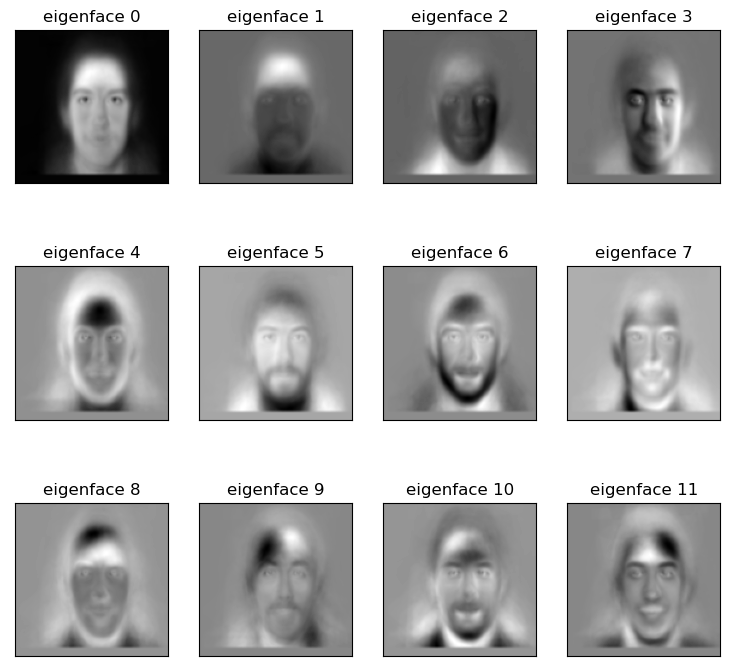

In [18]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 128, 128)

plt.show()

保存PCA特征降维后的数据集

In [60]:
#保存数据集
print('trainPCA.shape = ', trainPCA.shape)
np.save('trainPCA.npy',trainPCA)
print('testPCA.shape = ', testPCA.shape)
np.save('testPCA.npy',testPCA)

trainPCA.shape =  (1995, 128)
testPCA.shape =  (1996, 128)


In [61]:
#加载数据集
trainPCA = np.load('trainPCA.npy')
testPCA = np.load('testPCA.npy')
print('trainPCA.shape = ', trainPCA.shape)
print('testPCA.shape = ', testPCA.shape)

trainPCA.shape =  (1995, 128)
testPCA.shape =  (1996, 128)


### 2.3 简单分类器验证PCA特征降维后的数据集的效果

KNN分类器

In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn_PCA = KNeighborsClassifier(5)
knn_PCA.fit(trainPCA, DR_sex_map)
print("knn_PCA.fit is ok")

knn_PCA.fit is ok


In [58]:
knn_PCA_pre = knn_PCA.predict(testPCA)
knn_PCA_accuracy = accuracy_score(DS_sex_map, knn_PCA_pre)
print('knn_PCA_accuracy = ', knn_PCA_accuracy)

knn_PCA_accuracy =  0.6222444889779559


C:\Users\Rama\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


SVM分类器

In [30]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

SVM_PCA = SVC(kernel='linear')
SVM_PCA.fit(trainPCA, DR_sex_map)

SVC(kernel='linear')

In [32]:
from sklearn.metrics import accuracy_score
SVM_PCA_pred = SVM_PCA.predict(testPCA)
accuracy_score(DS_sex_map, SVM_PCA_pred)

0.7164328657314629

## 3. LBP局部二元模式处理

In [3]:
from skimage.feature import local_binary_pattern

dlib提取人脸图像，并将图像统一变换为64*64

In [4]:
def dlib_LBP(img_data) :
    detector = dlib.get_frontal_face_detector()    #获取人脸位置检测器
    img_data = cv2.cvtColor(img_data, cv2.COLOR_GRAY2BGR)    #原图为灰度图，而dlib读取RGB图，故需要做格式转换
    detect_face = detector(img_data, 1)    #1表示上采样，即将图片放大后再进行采样，能够捕获更精准的特征点
    for index, face in enumerate(detect_face):    #通过循环拿出dectector的输出
        dlib_left = face.left()
        dlib_top = face.top()
        dlib_right = face.right()
        dlib_bottom = face.bottom()
    if 'dlib_top' in dir():
        img_out = img_data[dlib_top:dlib_bottom, dlib_left:dlib_right]
    else:
        img_out = img_data[32:96, 32:96]
    img_out = cv2.resize(img_out, (64, 64), interpolation=cv2.INTER_CUBIC)
    img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2GRAY)   #转换回灰度图
    return img_out

### 3.1 LBPH直方图特征

以LBP图像的统计直方图作为特征

#### 3.1.1 构建LBPH数据集

In [19]:
trainLBP = []

for dataDR in trainData:
    dataDR = dlib_LBP(dataDR)
    img_LBP = local_binary_pattern(image=dataDR, P=8, R=1, method='default')
    img_LBP = img_LBP.astype(np.uint8)
    hist_LBP = cv2.calcHist([img_LBP], channels=[0], mask=None, histSize=[128], ranges=[0,256])  #histSize=130是为了保证最终去掉2维黑色背景影响后，剩余特征维度为128
    hist_LBP = np.squeeze(hist_LBP.reshape(1,128))
    trainLBP.append(hist_LBP)
    
trainLBP = np.array(trainLBP)
print('OK')

OK


In [20]:
testLBP = []

for dataDS in testData:
    dataDS = dlib_LBP(dataDS)
    img_LBP = local_binary_pattern(image=dataDS, P=8, R=1, method='default')
    img_LBP = img_LBP.astype(np.uint8)
    hist_LBP = cv2.calcHist([img_LBP], channels=[0], mask=None, histSize=[128], ranges=[0,256])  #histSize=130是为了保证最终去掉2维黑色背景影响后，剩余特征维度为128
    hist_LBP = np.squeeze(hist_LBP.reshape(1,128))
    testLBP.append(hist_LBP)
    
testLBP = np.array(testLBP)
print('OK')

OK


由于数据集构建速度很慢，故将数据集保存加载

In [42]:
#保存LBPH数据集
print('trainLBP.shape = ', trainLBP.shape)
np.save('data/trainLBP.npy',trainLBP)
print('testLBP.shape = ', testLBP.shape)
np.save('data/testLBP.npy',testLBP)

trainLBP.shape =  (1995, 128)
testLBP.shape =  (1996, 128)


In [43]:
#加载LBPH数据集
trainLBP = np.load('data/trainLBP.npy')
testLBP = np.load('data/testLBP.npy')
print('trainLBP.shape = ', trainLBP.shape)
print('testLBP.shape = ', testLBP.shape)

trainLBP.shape =  (1995, 128)
testLBP.shape =  (1996, 128)


#### 3.1.2 分类器性能测试

数据集标准化

In [49]:
from sklearn.preprocessing import StandardScaler    #数据标准化
LBP_SDclf = StandardScaler()
LBP_SDclf.fit(trainLBP)
trainLBP_std = LBP_SDclf.transform(trainLBP)
testLBP_std = LBP_SDclf.transform(testLBP)

KNN分类器

In [50]:
from sklearn.neighbors import KNeighborsClassifier
knn_LBP = KNeighborsClassifier(5)
knn_LBP.fit(trainLBP_std, DR_sex_map)
print("knn_LBP.fit is ok")

knn_LBP.fit is ok


In [51]:
knn_LBP_pre = knn_LBP.predict(testLBP_std)
knn_LBP_accuracy = accuracy_score(DS_sex_map, knn_LBP_pre)
print('knn_LBP_accuracy = ', knn_LBP_accuracy)

knn_LBP_accuracy =  0.5861723446893787


C:\Users\Rama\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


SVM分类器

In [53]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

SVM_LBP = SVC(kernel='linear')
SVM_LBP.fit(trainLBP_std, DR_sex_map)

SVC(kernel='linear')

In [54]:
from sklearn.metrics import accuracy_score
SVM_LBP_pred = SVM_LBP.predict(testLBP_std)
accuracy_score(DS_sex_map, SVM_LBP_pred)

0.6042084168336673

### 3.2 dlib人脸探测+LBP提取+PCA特征降维

#### 3.2.1 LBP图像提取及PCA特征降维

LBP图像提取

In [18]:
trainLBP_PCA = []

for dataDR in trainData:
    dataDR = dlib_LBP(dataDR)
    img_LBP = local_binary_pattern(image=dataDR, P=8, R=1, method='default')
    img_LBP = img_LBP.astype(np.uint8)
    trainLBP_PCA.append(img_LBP)
    
trainLBP_PCA = np.array(trainLBP_PCA)
print('OK')

OK


In [19]:
trainLBP_PCA.shape

(1995, 64, 64)

In [20]:
testLBP_PCA = []

for dataDS in testData:
    dataDS = dlib_LBP(dataDS)
    img_LBP = local_binary_pattern(image=dataDR, P=8, R=1, method='default')
    img_LBP = img_LBP.astype(np.uint8)
    testLBP_PCA.append(img_LBP)
    
testLBP_PCA = np.array(testLBP_PCA)
print('OK')

OK


In [22]:
testLBP_PCA.shape

(1996, 64, 64)

对LBP图像数据集做PCA特征降维

In [23]:
from sklearn.decomposition import PCA
trainLBP_PCA = trainLBP_PCA.reshape(1995, 4096)
testLBP_PCA = testLBP_PCA.reshape(1996, 4096)
LBP_PCA = PCA(n_components=128, svd_solver='randomized',
          whiten=True).fit(testLBP_PCA)
trainLBP_PCA = LBP_PCA.fit_transform(trainLBP_PCA)
testLBP_PCA = LBP_PCA.fit_transform(testLBP_PCA)

C:\Users\Rama\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:595: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()
C:\Users\Rama\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:595: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


In [46]:
#保存数据集
print('trainLBP_PCA.shape = ', trainLBP_PCA.shape)
np.save('data/trainLBP_PCA.npy',trainLBP_PCA)
print('testLBP_PCA.shape = ', testLBP_PCA.shape)
np.save('data/testLBP_PCA.npy',testLBP_PCA)

trainLBP_PCA.shape =  (1995, 128)
testLBP_PCA.shape =  (1996, 128)


In [44]:
#加载数据集
trainLBP_PCA = np.load('data/trainLBP_PCA.npy')
testLBP_PCA = np.load('data/testLBP_PCA.npy')
print('trainLBP_PCA.shape = ', trainLBP_PCA.shape)
print('testLBP_PCA.shape = ', testLBP_PCA.shape)

trainLBP_PCA.shape =  (1995, 128)
testLBP_PCA.shape =  (1996, 128)


#### 3.2.2 分类器性能测试

数据集标准化

In [28]:
from sklearn.preprocessing import StandardScaler    #数据标准化
LBP_PCA_SD = StandardScaler()
LBP_PCA_SD.fit(trainLBP_PCA)
trainLBP_PCA_std = LBP_PCA_SD.transform(trainLBP_PCA)
testLBP_PCA_std = LBP_PCA_SD.transform(testLBP_PCA)

KNN分类器

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn_LBP_PCA = KNeighborsClassifier(5)
knn_LBP_PCA.fit(trainLBP_PCA_std, DR_sex_map)
print("knn_LBP_PCA.fit is ok")

knn_LBP_PCA.fit is ok


In [42]:
knn_LBP_PCA_pre = knn_LBP_PCA.predict(testLBP_PCA)
knn_LBP_PCA_accuracy = accuracy_score(DS_sex_map, knn_LBP_PCA_pre)
print('knn_LBP_PCA_accuracy = ', knn_LBP_PCA_accuracy)

knn_LBP_PCA_accuracy =  0.6437875751503006


C:\Users\Rama\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


SVM分类器

In [45]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

SVM_LBP_PCA = SVC(kernel='linear')
SVM_LBP_PCA.fit(trainLBP_PCA_std, DR_sex_map)

SVC(kernel='linear')

In [46]:
from sklearn.metrics import accuracy_score
SVM_LBP_PCA_pred = SVM_LBP_PCA.predict(testLBP_PCA_std)
accuracy_score(DS_sex_map, SVM_LBP_PCA_pred)

0.6432865731462926

In [12]:
from cv2 import face
recognizer=face.
recognizer.train(trainData,DR_sex_map)